##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Basic text classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/text_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates text classification starting from plain text files stored on disk. You'll train a binary classifier to perform sentiment analysis on an IMDB dataset. At the end of the notebook, there is an exercise for you to try, in which you'll train a multi-class classifier to predict the tag for a programming question on Stack Overflow.


In [3]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.8.0
    Uninstalling typing-extensions-4.8.0:
      Successfully uninstalled typing-extensions-4.8.0


In [4]:
!pip install --upgrade h5py
!pip install numpy==1.24.3

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: h5py in /sfs/qumulo/qhome/sws2vn/.local/lib/python3.8/site-packages (3.10.0)
Defaulting to user installation because normal site-packages is not writeable


In [5]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses


In [6]:
print(tf.__version__)

2.13.1


## Sentiment analysis

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review. This is an example of *binary*—or two-class—classification, an important and widely applicable kind of machine learning problem.

You'll use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are *balanced*, meaning they contain an equal number of positive and negative reviews.


### Download and explore the IMDB dataset

Let's download and extract the dataset, then explore the directory structure.

In [7]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [8]:
os.listdir(dataset_dir)

['train', 'imdb.vocab', 'README', 'test', 'imdbEr.txt']

In [9]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['unsup',
 'pos',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_unsup.txt',
 'labeledBow.feat',
 'urls_pos.txt',
 'neg']

The `aclImdb/train/pos` and `aclImdb/train/neg` directories contain many text files, each of which is a single movie review. Let's take a look at one of them.

In [10]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


### Load the dataset

Next, you will load the data off disk and prepare it into a format suitable for training. To do so, you will use the helpful [text_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory) utility, which expects a directory structure as follows.

```
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
```

To prepare a dataset for binary classification, you will need two folders on disk, corresponding to `class_a` and `class_b`. These will be the positive and negative movie reviews, which can be found in  `aclImdb/train/pos` and `aclImdb/train/neg`. As the IMDB dataset contains additional folders, you will remove them before using this utility.

In [11]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`. [tf.data](https://www.tensorflow.org/guide/data) is a powerful collection of tools for working with data.

When running a machine learning experiment, it is a best practice to divide your dataset into three splits: [train](https://developers.google.com/machine-learning/glossary#training_set), [validation](https://developers.google.com/machine-learning/glossary#validation_set), and [test](https://developers.google.com/machine-learning/glossary#test-set).

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

In [12]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


As you can see above, there are 25,000 examples in the training folder, of which you will use 80% (or 20,000) for training. As you will see in a moment, you can train a model by passing a dataset directly to `model.fit`. If you're new to `tf.data`, you can also iterate over the dataset and print out a few examples as follows.

In [13]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

Notice the reviews contain raw text (with punctuation and occasional HTML tags like `<br/>`). You will show how to handle these in the following section.

The labels are 0 or 1. To see which of these correspond to positive and negative movie reviews, you can check the `class_names` property on the dataset.


In [14]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


Next, you will create a validation and test dataset. You will use the remaining 5,000 reviews from the training set for validation.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [15]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [16]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


### Prepare the dataset for training

Next, you will standardize, tokenize, and vectorize the data using the helpful `tf.keras.layers.TextVectorization` layer.

Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). Vectorization refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

As you saw above, the reviews contain various HTML tags like `<br />`. These tags will not be removed by the default standardizer in the `TextVectorization` layer (which converts text to lowercase and strips punctuation by default, but doesn't strip HTML). You will write a custom standardization function to remove the HTML.

Note: To prevent [training-testing skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew) (also known as training-serving skew), it is important to preprocess the data identically at train and test time. To facilitate this, the `TextVectorization` layer can be included directly inside your model, as shown later in this tutorial.

In [17]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Next, you will create a `TextVectorization` layer. You will use this layer to standardize, tokenize, and vectorize our data. You set the `output_mode` to `int` to create unique integer indices for each token.

Note that you're using the default split function, and the custom standardization function you defined above. You'll also define some constants for the model, like an explicit maximum `sequence_length`, which will cause the layer to pad or truncate sequences to exactly `sequence_length` values.

In [18]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Next, you will call `adapt` to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

Note: It's important to only use your training data when calling adapt (using the test set would leak information).

In [19]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Let's create a function to see the result of using this layer to preprocess some data.

In [20]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [21]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

As you can see above, each token has been replaced by an integer. You can lookup the token (string) that each integer corresponds to by calling `.get_vocabulary()` on the layer.

In [22]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


You are nearly ready to train your model. As a final preprocessing step, you will apply the TextVectorization layer you created earlier to the train, validation, and test dataset.

In [23]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Configure the dataset for performance

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

`.cache()` keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

`.prefetch()` overlaps data preprocessing and model execution while training.

You can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance).

In [24]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

It's time to create your neural network:

In [30]:
embedding_dim = 16

In [31]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160033 (625.13 KB)
Trainable params: 160033 (625.13 KB)
Non-trainable params: 0 (0.00 Byte)
________________

The layers are stacked sequentially to build the classifier:

1. The first layer is an `Embedding` layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`.  To learn more about embeddings, check out the [Word embeddings](https://www.tensorflow.org/text/guide/word_embeddings) tutorial.
2. Next, a `GlobalAveragePooling1D` layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
3. The last layer is densely connected with a single output node.

### Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), you'll use `losses.BinaryCrossentropy` loss function.

Now, configure the model to use an optimizer and a loss function:

In [32]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

### Train the model

You will train the model by passing the `dataset` object to the fit method.

In [33]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 16s 25ms/step - loss: 0.6624 - binary_accuracy: 0.6969 - val_loss: 0.6129 - val_binary_accuracy: 0.7760
Epoch 2/10
625/625 [==============================] - 2s 3ms/step - loss: 0.5467 - binary_accuracy: 0.8035 - val_loss: 0.4970 - val_binary_accuracy: 0.8252
Epoch 3/10
625/625 [==============================] - 2s 3ms/step - loss: 0.4434 - binary_accuracy: 0.8457 - val_loss: 0.4190 - val_binary_accuracy: 0.8476
Epoch 4/10
625/625 [==============================] - 2s 3ms/step - loss: 0.3779 - binary_accuracy: 0.8655 - val_loss: 0.3731 - val_binary_accuracy: 0.8612
Epoch 5/10
625/625 [==============================] - 2s 3ms/step - loss: 0.3348 - binary_accuracy: 0.8787 - val_loss: 0.3444 - val_binary_accuracy: 0.8672
Epoch 6/10
625/625 [==============================] - 2s 3ms/step - loss: 0.3038 - binary_accuracy: 0.8893 - val_loss: 0.3253 - val_binary_accuracy: 0.8720
Epoch 7/10
625/625 [==============================] - 2s 3ms/s

### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [34]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 14s 18ms/step - loss: 0.3098 - binary_accuracy: 0.8746
Loss:  0.30982357263565063
Accuracy:  0.8745599985122681


This fairly naive approach achieves an accuracy of about 86%.

### Create a plot of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [95]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

There are four entries: one for each monitored metric during training and validation. You can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

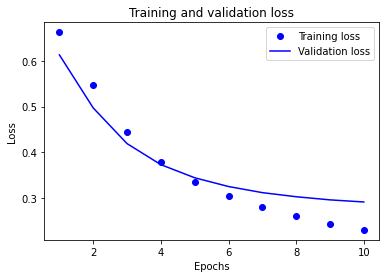

In [36]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

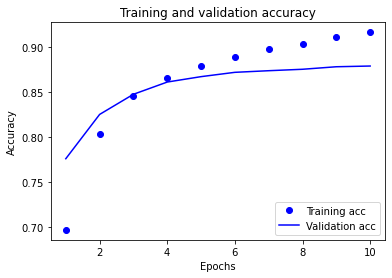

In [37]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss *decreases* with each epoch and the training accuracy *increases* with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak before the training accuracy. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations *specific* to the training data that do not *generalize* to test data.

For this particular case, you could prevent overfitting by simply stopping the training when the validation accuracy is no longer increasing. One way to do so is to use the `tf.keras.callbacks.EarlyStopping` callback.

## Export the model

In the code above, you applied the `TextVectorization` layer to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the `TextVectorization` layer inside your model. To do so, you can create a new model using the weights you just trained.

In [38]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 13s 17ms/step - loss: 0.3098 - accuracy: 0.8746
0.8745599985122681


### Inference on new data

To get predictions for new examples, you can simply call `model.predict()`.

In [39]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

1/1 [==============================] - 0s 97ms/step


array([[0.61951137],
       [0.4410317 ],
       [0.3570895 ]], dtype=float32)

Including the text preprocessing logic inside your model enables you to export a model for production that simplifies deployment, and reduces the potential for [train/test skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew).

There is a performance difference to keep in mind when choosing where to apply your TextVectorization layer. Using it outside of your model enables you to do asynchronous CPU processing and buffering of your data when training on GPU. So, if you're training your model on the GPU, you probably want to go with this option to get the best performance while developing your model, then switch to including the TextVectorization layer inside your model when you're ready to prepare for deployment.

Visit this [tutorial](https://www.tensorflow.org/tutorials/keras/save_and_load) to learn more about saving models.

# Below are Alternative Models Tried 

# Alternative Model 1: Same as Original Model except increased Sequence Length to 650 previously 250

Check text lengths in dataset

In [119]:
import numpy as np
text_lengths = []

for text_batch, _ in raw_train_ds:
    text_lengths.extend([len(text) for text in text_batch.numpy()])

text_lengths = np.array(text_lengths)

average_length = np.mean(text_lengths)
min_length = np.min(text_lengths)
max_length = np.max(text_lengths)

unique_lengths, counts = np.unique(text_lengths, return_counts=True)
mode_length = unique_lengths[np.argmax(counts)]

print("Average Text Length:", average_length)
print("Minimum Text Length:", min_length)
print("Maximum Text Length:", max_length)
print("Mode Text Length:", mode_length)

Average Text Length: 1327.7886
Minimum Text Length: 52
Maximum Text Length: 13704
Mode Text Length: 659


In [120]:
text_lengths

array([4527,  770,  976, ..., 1120,  842,  512])

In [121]:
text_lengths_test = []

for text_batch, _ in raw_test_ds:
    text_lengths_test.extend([len(text) for text in text_batch.numpy()])

text_lengths_test = np.array(text_lengths_test)

average_length = np.mean(text_lengths_test)
min_length = np.min(text_lengths_test)
max_length = np.max(text_lengths_test)

unique_lengths, counts = np.unique(text_lengths_test, return_counts=True)
mode_length = unique_lengths[np.argmax(counts)]

print("Average Text Length:", average_length)
print("Minimum Text Length:", min_length)
print("Maximum Text Length:", max_length)
print("Mode Text Length:", mode_length)

Average Text Length: 1294.0274
Minimum Text Length: 32
Maximum Text Length: 12988
Mode Text Length: 670


In [122]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [123]:
max_features_v2 = 10000  # kept as 10,000
sequence_length_v2 = 650 # previously 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features_v2,
    output_mode='int',
    output_sequence_length=sequence_length_v2)

In [124]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [125]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [126]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [127]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

It's time to create your neural network:

In [128]:
embedding_dim = 16

In [129]:
model = tf.keras.Sequential([
  layers.Embedding(max_features_v2 + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout_9 (Dropout)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d_3  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_10 (Dropout)        (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160033 (625.13 KB)
Trainable params: 160033 (625.13 KB)
Non-trainable params: 0 (0.00 Byte)
______________

In [130]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

### Train the model

You will train the model by passing the `dataset` object to the fit method.

In [131]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 17s 26ms/step - loss: 0.6830 - binary_accuracy: 0.6152 - val_loss: 0.6640 - val_binary_accuracy: 0.6986
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.6254 - binary_accuracy: 0.7509 - val_loss: 0.5900 - val_binary_accuracy: 0.7888
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.5447 - binary_accuracy: 0.8075 - val_loss: 0.5168 - val_binary_accuracy: 0.8220
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 0.4753 - binary_accuracy: 0.8403 - val_loss: 0.4577 - val_binary_accuracy: 0.8420
Epoch 5/10
625/625 [==============================] - 3s 5ms/step - loss: 0.4194 - binary_accuracy: 0.8614 - val_loss: 0.4131 - val_binary_accuracy: 0.8560
Epoch 6/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3778 - binary_accuracy: 0.8746 - val_loss: 0.3804 - val_binary_accuracy: 0.8654
Epoch 7/10
625/625 [==============================] - 3s 5ms/s

### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [132]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 17s 22ms/step - loss: 0.3209 - binary_accuracy: 0.8795
Loss:  0.32094115018844604
Accuracy:  0.8795199990272522


In [133]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

### Create a plot of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

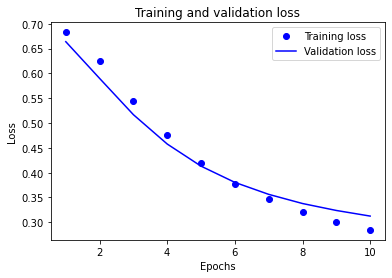

In [134]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

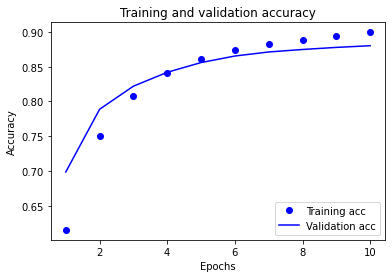

In [135]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

Similar results as Original Model overall. 

# Alternative Model 2: Same as Original Model except Increased Sequence Length to 650 previously 250, decreased max_features to 5,000 previously 10,000, and increased Epochs to 20 previously 10

In [136]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [137]:
max_features_v2 = 5000  # previously 10,000
sequence_length_v2 = 650 # previously 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features_v2,
    output_mode='int',
    output_sequence_length=sequence_length_v2)

In [138]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [139]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [140]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [141]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

It's time to create your neural network:

In [142]:
embedding_dim = 16 

In [143]:
model = tf.keras.Sequential([
  layers.Embedding(max_features_v2 + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, None, 16)          80016     
                                                                 
 dropout_11 (Dropout)        (None, None, 16)          0         
                                                                 
 global_average_pooling1d_4  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_12 (Dropout)        (None, 16)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 17        
                                                                 
Total params: 80033 (312.63 KB)
Trainable params: 80033 (312.63 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [144]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

### Train the model

You will train the model by passing the `dataset` object to the fit method.

In [145]:
epochs = 20 # increased epochs previously 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/20
625/625 [==============================] - 19s 29ms/step - loss: 0.6814 - binary_accuracy: 0.6216 - val_loss: 0.6607 - val_binary_accuracy: 0.6772
Epoch 2/20
625/625 [==============================] - 3s 5ms/step - loss: 0.6218 - binary_accuracy: 0.7460 - val_loss: 0.5874 - val_binary_accuracy: 0.7814
Epoch 3/20
625/625 [==============================] - 3s 5ms/step - loss: 0.5446 - binary_accuracy: 0.8028 - val_loss: 0.5174 - val_binary_accuracy: 0.8140
Epoch 4/20
625/625 [==============================] - 3s 5ms/step - loss: 0.4784 - binary_accuracy: 0.8344 - val_loss: 0.4608 - val_binary_accuracy: 0.8404
Epoch 5/20
625/625 [==============================] - 3s 5ms/step - loss: 0.4265 - binary_accuracy: 0.8552 - val_loss: 0.4181 - val_binary_accuracy: 0.8528
Epoch 6/20
625/625 [==============================] - 3s 5ms/step - loss: 0.3871 - binary_accuracy: 0.8661 - val_loss: 0.3877 - val_binary_accuracy: 0.8628
Epoch 7/20
625/625 [==============================] - 3s 5ms/s

### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [146]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 16s 21ms/step - loss: 0.2850 - binary_accuracy: 0.8878
Loss:  0.28504514694213867
Accuracy:  0.8877999782562256


In [147]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

### Create a plot of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

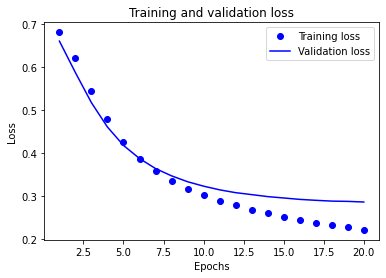

In [148]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

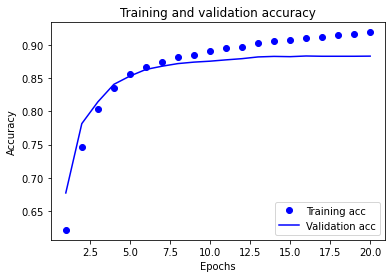

In [149]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

Small improvement relative to original model 

# Alternative Model 3: Increase Sequence Length to 650 previously 250, decrease max_features to 5,000 previously 10,000, increased epochs to 20 previously 10, and increased embedding dims to 50 previously 16. 

In [150]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [151]:
max_features_v2 = 5000  # previously 10,000
sequence_length_v2 = 650 # previously 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features_v2,
    output_mode='int',
    output_sequence_length=sequence_length_v2)

In [152]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [153]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [154]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [155]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

It's time to create your neural network:

In [156]:
embedding_dim = 50 # previoulsy 16 

In [157]:
model = tf.keras.Sequential([
  layers.Embedding(max_features_v2 + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, None, 50)          250050    
                                                                 
 dropout_13 (Dropout)        (None, None, 50)          0         
                                                                 
 global_average_pooling1d_5  (None, 50)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_14 (Dropout)        (None, 50)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 250101 (976.96 KB)
Trainable params: 250101 (976.96 KB)
Non-trainable params: 0 (0.00 Byte)
______________

In [158]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

### Train the model

You will train the model by passing the `dataset` object to the fit method.

In [159]:
epochs = 20 # increased epochs previously 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/20
625/625 [==============================] - 17s 26ms/step - loss: 0.6701 - binary_accuracy: 0.6400 - val_loss: 0.6267 - val_binary_accuracy: 0.7432
Epoch 2/20
625/625 [==============================] - 10s 16ms/step - loss: 0.5596 - binary_accuracy: 0.7858 - val_loss: 0.5068 - val_binary_accuracy: 0.8202
Epoch 3/20
625/625 [==============================] - 10s 16ms/step - loss: 0.4506 - binary_accuracy: 0.8438 - val_loss: 0.4229 - val_binary_accuracy: 0.8530
Epoch 4/20
625/625 [==============================] - 10s 15ms/step - loss: 0.3813 - binary_accuracy: 0.8669 - val_loss: 0.3743 - val_binary_accuracy: 0.8648
Epoch 5/20
625/625 [==============================] - 10s 16ms/step - loss: 0.3383 - binary_accuracy: 0.8787 - val_loss: 0.3456 - val_binary_accuracy: 0.8684
Epoch 6/20
625/625 [==============================] - 10s 16ms/step - loss: 0.3100 - binary_accuracy: 0.8864 - val_loss: 0.3264 - val_binary_accuracy: 0.8732
Epoch 7/20
625/625 [==============================] 

### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [160]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 16s 20ms/step - loss: 0.2951 - binary_accuracy: 0.8856
Loss:  0.29514825344085693
Accuracy:  0.885640025138855


In [161]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

### Create a plot of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

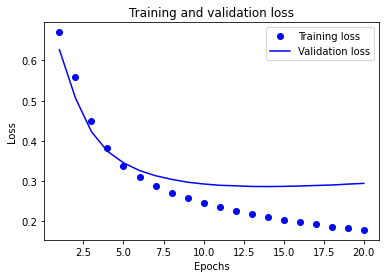

In [162]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

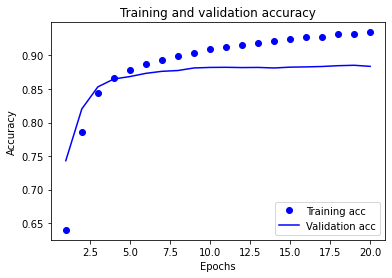

In [163]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

# Alternative Model 4: Bidirectional LSTM

In [32]:
from tensorflow import keras

max_features_v2 = 10000  # kept as 10,000
sequence_length_v2 = 650 # previously 250

inputs = tf.keras.Input(shape=(None,), dtype="int32")
x = layers.Embedding(max_features_v2, 128)(inputs)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_bilstm = keras.Model(inputs, outputs)
model_bilstm.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 128)         1280000   
                                                                 
 bidirectional (Bidirection  (None, None, 128)         98816     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1477761 (5.64 MB)
Trainable params: 1477761 (5.

Used Binary Accuracy as the metrics measure

In [62]:
model_bilstm.compile(loss=losses.BinaryCrossentropy(from_logits=False),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [63]:
history = model_bilstm.fit(train_ds, validation_data=val_ds, epochs=10, batch_size=32) 

Epoch 1/10
625/625 [==============================] - 849s 1s/step - loss: 0.4942 - binary_accuracy: 0.4981 - val_loss: 0.3821 - val_binary_accuracy: 0.5076
Epoch 2/10
625/625 [==============================] - 831s 1s/step - loss: 0.3963 - binary_accuracy: 0.4981 - val_loss: 0.5364 - val_binary_accuracy: 0.5076
Epoch 3/10
625/625 [==============================] - 824s 1s/step - loss: 0.2820 - binary_accuracy: 0.4981 - val_loss: 0.3525 - val_binary_accuracy: 0.5076
Epoch 4/10
625/625 [==============================] - 809s 1s/step - loss: 0.2353 - binary_accuracy: 0.4981 - val_loss: 0.3592 - val_binary_accuracy: 0.5076
Epoch 5/10
625/625 [==============================] - 808s 1s/step - loss: 0.2085 - binary_accuracy: 0.4981 - val_loss: 0.3738 - val_binary_accuracy: 0.5076
Epoch 6/10
625/625 [==============================] - 806s 1s/step - loss: 0.1567 - binary_accuracy: 0.4981 - val_loss: 0.4305 - val_binary_accuracy: 0.5076
Epoch 7/10
625/625 [==============================] - 809s

Used Accuracy as the metrics measure instead of Binary Accuracy otherwise the same model

In [34]:
model_bilstm.compile(loss=losses.BinaryCrossentropy(from_logits=False),
              optimizer='adam',
              metrics=['accuracy'])

In [35]:
history = model_bilstm.fit(train_ds, validation_data=val_ds, epochs=10, batch_size=32)

Epoch 1/10
625/625 [==============================] - 304s 478ms/step - loss: 0.5199 - accuracy: 0.7461 - val_loss: 0.4272 - val_accuracy: 0.8232
Epoch 2/10
625/625 [==============================] - 290s 465ms/step - loss: 0.3680 - accuracy: 0.8479 - val_loss: 0.3912 - val_accuracy: 0.8326
Epoch 3/10
625/625 [==============================] - 292s 467ms/step - loss: 0.3360 - accuracy: 0.8605 - val_loss: 0.5385 - val_accuracy: 0.7804
Epoch 4/10
625/625 [==============================] - 293s 469ms/step - loss: 0.3459 - accuracy: 0.8583 - val_loss: 0.3703 - val_accuracy: 0.8292
Epoch 5/10
625/625 [==============================] - 293s 469ms/step - loss: 0.2340 - accuracy: 0.9082 - val_loss: 0.3497 - val_accuracy: 0.8442
Epoch 6/10
625/625 [==============================] - 294s 470ms/step - loss: 0.1861 - accuracy: 0.9327 - val_loss: 0.3662 - val_accuracy: 0.8638
Epoch 7/10
625/625 [==============================] - 293s 469ms/step - loss: 0.1603 - accuracy: 0.9445 - val_loss: 0.3595 -

In [36]:
loss, accuracy = model_bilstm.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 79s 101ms/step - loss: 0.6399 - accuracy: 0.8068
Loss:  0.6398623585700989
Accuracy:  0.8067600131034851


In [37]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

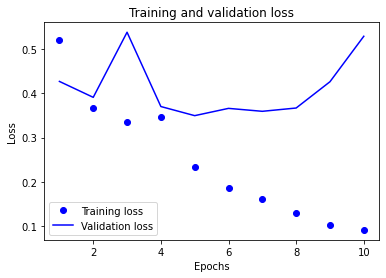

In [38]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

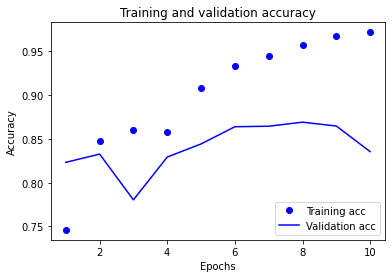

In [39]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

Performed much worse than the original model. 

# Alternative Model 5 Bidirectional LSTM (grid search for batch size)

In [40]:
from tensorflow import keras

max_features_v2 = 10000  # previously 10,000
sequence_length_v2 = 650 # previously 250

inputs = tf.keras.Input(shape=(None,), dtype="int32")
x = layers.Embedding(max_features_v2, 128)(inputs)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_bilstm2 = keras.Model(inputs, outputs)
model_bilstm2.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 128)         1280000   
                                                                 
 bidirectional_2 (Bidirecti  (None, None, 128)         98816     
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1477761 (5.64 MB)
Trainable params: 1477761 (

In [41]:
model_bilstm.compile(loss=losses.BinaryCrossentropy(from_logits=False),
              optimizer='adam',
              metrics=['accuracy'])

Training with a batch size of 8
Epoch 1/10
625/625 [==============================] - 292s 468ms/step - loss: 0.0574 - accuracy: 0.9814 - val_loss: 0.5226 - val_accuracy: 0.8586
Epoch 2/10
625/625 [==============================] - 292s 468ms/step - loss: 0.0506 - accuracy: 0.9840 - val_loss: 0.5047 - val_accuracy: 0.8606
Epoch 3/10
625/625 [==============================] - 293s 469ms/step - loss: 0.0365 - accuracy: 0.9895 - val_loss: 0.5138 - val_accuracy: 0.8510
Epoch 4/10
625/625 [==============================] - 293s 469ms/step - loss: 0.0254 - accuracy: 0.9937 - val_loss: 0.6332 - val_accuracy: 0.8316
Epoch 5/10
625/625 [==============================] - 293s 469ms/step - loss: 0.0190 - accuracy: 0.9955 - val_loss: 0.6364 - val_accuracy: 0.8550
Epoch 6/10
625/625 [==============================] - 293s 469ms/step - loss: 0.0204 - accuracy: 0.9944 - val_loss: 0.7169 - val_accuracy: 0.8458
Epoch 7/10
625/625 [==============================] - 293s 469ms/step - loss: 0.0206 - accur

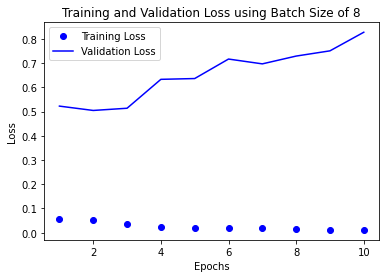

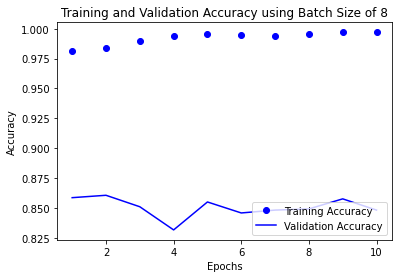

Training with a batch size of 16
Epoch 1/10
625/625 [==============================] - 293s 469ms/step - loss: 0.0112 - accuracy: 0.9973 - val_loss: 0.6732 - val_accuracy: 0.8534
Epoch 2/10
625/625 [==============================] - 291s 466ms/step - loss: 0.0090 - accuracy: 0.9983 - val_loss: 0.8116 - val_accuracy: 0.8540
Epoch 3/10
625/625 [==============================] - 291s 465ms/step - loss: 0.0089 - accuracy: 0.9977 - val_loss: 0.9338 - val_accuracy: 0.8516
Epoch 4/10
625/625 [==============================] - 290s 464ms/step - loss: 0.0098 - accuracy: 0.9974 - val_loss: 0.8469 - val_accuracy: 0.8500
Epoch 5/10
625/625 [==============================] - 290s 465ms/step - loss: 0.0084 - accuracy: 0.9981 - val_loss: 0.7724 - val_accuracy: 0.8506
Epoch 6/10
625/625 [==============================] - 290s 465ms/step - loss: 0.0056 - accuracy: 0.9987 - val_loss: 0.9039 - val_accuracy: 0.8526
Epoch 7/10
625/625 [==============================] - 290s 464ms/step - loss: 0.0082 - accu

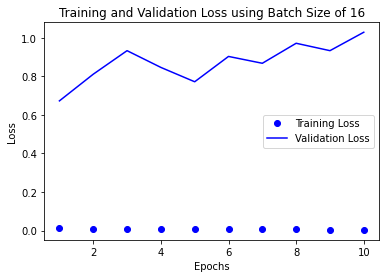

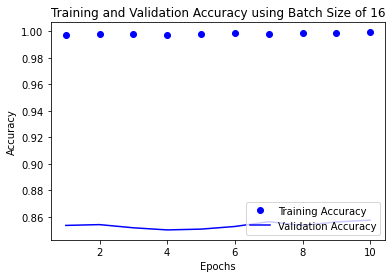

Training with a batch size of 32
Epoch 1/10
625/625 [==============================] - 293s 468ms/step - loss: 0.0025 - accuracy: 0.9995 - val_loss: 1.0714 - val_accuracy: 0.8500
Epoch 2/10
625/625 [==============================] - 292s 467ms/step - loss: 0.0053 - accuracy: 0.9987 - val_loss: 0.9907 - val_accuracy: 0.8516
Epoch 3/10
625/625 [==============================] - 293s 468ms/step - loss: 0.0070 - accuracy: 0.9981 - val_loss: 0.8287 - val_accuracy: 0.8490
Epoch 4/10
625/625 [==============================] - 293s 468ms/step - loss: 0.0038 - accuracy: 0.9991 - val_loss: 1.0267 - val_accuracy: 0.8462
Epoch 5/10
625/625 [==============================] - 293s 469ms/step - loss: 0.0026 - accuracy: 0.9992 - val_loss: 1.1384 - val_accuracy: 0.8452
Epoch 6/10
625/625 [==============================] - 292s 468ms/step - loss: 6.6556e-04 - accuracy: 0.9998 - val_loss: 1.1903 - val_accuracy: 0.8460
Epoch 7/10
625/625 [==============================] - 293s 468ms/step - loss: 5.4004e-0

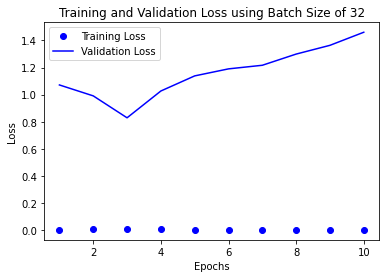

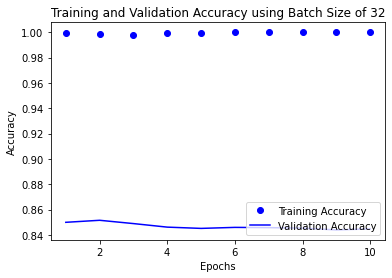

Training with a batch size of 64
Epoch 1/10
625/625 [==============================] - 291s 466ms/step - loss: 1.2567e-05 - accuracy: 1.0000 - val_loss: 1.5224 - val_accuracy: 0.8446
Epoch 2/10
625/625 [==============================] - 292s 467ms/step - loss: 7.5007e-06 - accuracy: 1.0000 - val_loss: 1.5781 - val_accuracy: 0.8448
Epoch 3/10
625/625 [==============================] - 293s 469ms/step - loss: 5.1846e-06 - accuracy: 1.0000 - val_loss: 1.6359 - val_accuracy: 0.8448
Epoch 4/10
625/625 [==============================] - 294s 470ms/step - loss: 3.2653e-06 - accuracy: 1.0000 - val_loss: 1.6913 - val_accuracy: 0.8442
Epoch 5/10
625/625 [==============================] - 293s 469ms/step - loss: 2.1768e-06 - accuracy: 1.0000 - val_loss: 1.7405 - val_accuracy: 0.8440
Epoch 6/10
625/625 [==============================] - 293s 468ms/step - loss: 1.4625e-06 - accuracy: 1.0000 - val_loss: 1.7840 - val_accuracy: 0.8446
Epoch 7/10
625/625 [==============================] - 293s 469ms/st

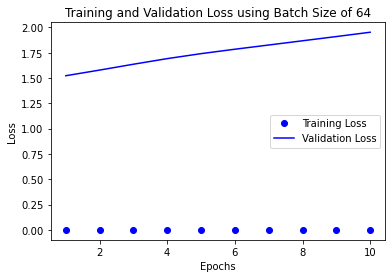

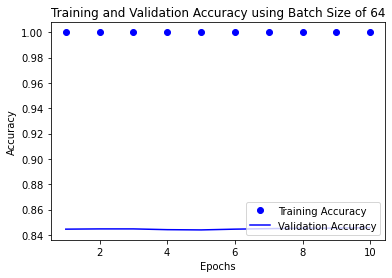

Training with a batch size of 128
Epoch 1/10
625/625 [==============================] - 292s 468ms/step - loss: 3.4989e-07 - accuracy: 1.0000 - val_loss: 1.9955 - val_accuracy: 0.8462
Epoch 2/10
625/625 [==============================] - 293s 468ms/step - loss: 2.6518e-07 - accuracy: 1.0000 - val_loss: 2.0395 - val_accuracy: 0.8454
Epoch 3/10
625/625 [==============================] - 294s 470ms/step - loss: 2.0056e-07 - accuracy: 1.0000 - val_loss: 2.0844 - val_accuracy: 0.8448
Epoch 4/10
625/625 [==============================] - 293s 470ms/step - loss: 1.5110e-07 - accuracy: 1.0000 - val_loss: 2.1286 - val_accuracy: 0.8452
Epoch 5/10
625/625 [==============================] - 293s 470ms/step - loss: 1.1388e-07 - accuracy: 1.0000 - val_loss: 2.1733 - val_accuracy: 0.8450
Epoch 6/10
625/625 [==============================] - 293s 469ms/step - loss: 8.5085e-08 - accuracy: 1.0000 - val_loss: 2.2179 - val_accuracy: 0.8454
Epoch 7/10
625/625 [==============================] - 293s 469ms/s

KeyboardInterrupt: 

In [43]:
batch_grid_vals = [8, 16, 32, 64, 128, 256]
for num_batch in batch_grid_vals:
  print(f"Training with a batch size of {num_batch}")
  history = model_bilstm.fit(train_ds, validation_data=val_ds, epochs=10, batch_size=num_batch)
  loss, accuracy = model_bilstm.evaluate(test_ds)

  print(f"On the test data using a batch size of {num_batch} produces a loss of {loss}")
  print(f"On the test data using a batch size of {num_batch} produces a accuracy of {accuracy}")

  history_dict = history.history
  acc = history_dict['accuracy']
  val_acc = history_dict['val_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(acc) + 1)

  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title(f'Training and Validation Loss using Batch Size of {num_batch}')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  plt.plot(epochs, acc, 'bo', label='Training Accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
  plt.title(f'Training and Validation Accuracy using Batch Size of {num_batch}')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.show()

Training with a batch size of 2
Epoch 1/10
625/625 [==============================] - 293s 469ms/step - loss: 4.4593e-08 - accuracy: 1.0000 - val_loss: 2.3078 - val_accuracy: 0.8450
Epoch 2/10
625/625 [==============================] - 293s 468ms/step - loss: 3.4113e-08 - accuracy: 1.0000 - val_loss: 2.3442 - val_accuracy: 0.8446
Epoch 3/10
625/625 [==============================] - 293s 468ms/step - loss: 2.6918e-08 - accuracy: 1.0000 - val_loss: 2.3768 - val_accuracy: 0.8446
Epoch 4/10
625/625 [==============================] - 293s 469ms/step - loss: 2.1667e-08 - accuracy: 1.0000 - val_loss: 2.4076 - val_accuracy: 0.8444
Epoch 5/10
625/625 [==============================] - 293s 468ms/step - loss: 1.7778e-08 - accuracy: 1.0000 - val_loss: 2.4373 - val_accuracy: 0.8442
Epoch 6/10
625/625 [==============================] - 292s 467ms/step - loss: 1.4717e-08 - accuracy: 1.0000 - val_loss: 2.4659 - val_accuracy: 0.8442
Epoch 7/10
625/625 [==============================] - 293s 469ms/ste

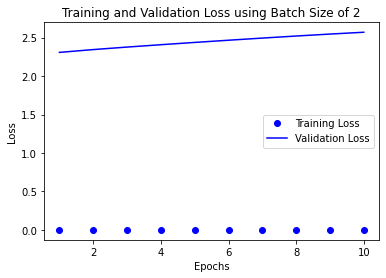

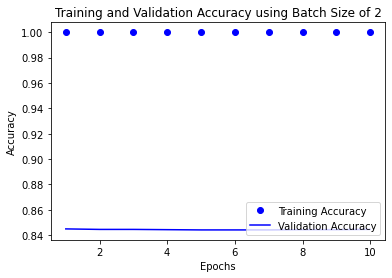

Training with a batch size of 4
Epoch 1/10
625/625 [==============================] - 293s 469ms/step - loss: 6.3324e-09 - accuracy: 1.0000 - val_loss: 2.5921 - val_accuracy: 0.8438
Epoch 2/10
625/625 [==============================] - 293s 469ms/step - loss: 5.4684e-09 - accuracy: 1.0000 - val_loss: 2.6132 - val_accuracy: 0.8444
Epoch 3/10
625/625 [==============================] - 294s 470ms/step - loss: 4.7674e-09 - accuracy: 1.0000 - val_loss: 2.6330 - val_accuracy: 0.8444
Epoch 4/10
625/625 [==============================] - 294s 470ms/step - loss: 4.1904e-09 - accuracy: 1.0000 - val_loss: 2.6512 - val_accuracy: 0.8444
Epoch 5/10
625/625 [==============================] - 293s 468ms/step - loss: 3.7089e-09 - accuracy: 1.0000 - val_loss: 2.6678 - val_accuracy: 0.8444
Epoch 6/10
625/625 [==============================] - 293s 469ms/step - loss: 3.3118e-09 - accuracy: 1.0000 - val_loss: 2.6839 - val_accuracy: 0.8440
Epoch 7/10
625/625 [==============================] - 293s 469ms/ste

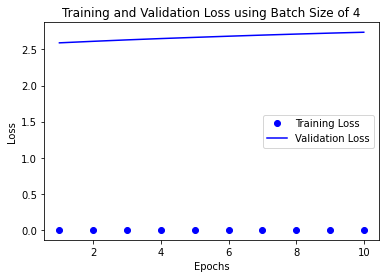

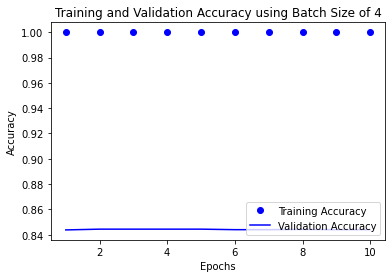

Training with a batch size of 6
Epoch 1/10
625/625 [==============================] - 294s 470ms/step - loss: 2.1094e-09 - accuracy: 1.0000 - val_loss: 2.7499 - val_accuracy: 0.8440
Epoch 2/10
625/625 [==============================] - 294s 470ms/step - loss: 1.9598e-09 - accuracy: 1.0000 - val_loss: 2.7607 - val_accuracy: 0.8440
Epoch 3/10
625/625 [==============================] - 293s 470ms/step - loss: 1.8324e-09 - accuracy: 1.0000 - val_loss: 2.7707 - val_accuracy: 0.8440
Epoch 4/10
625/625 [==============================] - 294s 470ms/step - loss: 1.7211e-09 - accuracy: 1.0000 - val_loss: 2.7805 - val_accuracy: 0.8440
Epoch 5/10
625/625 [==============================] - 294s 470ms/step - loss: 1.6206e-09 - accuracy: 1.0000 - val_loss: 2.7892 - val_accuracy: 0.8436
Epoch 6/10
625/625 [==============================] - 294s 470ms/step - loss: 1.5340e-09 - accuracy: 1.0000 - val_loss: 2.7954 - val_accuracy: 0.8440
Epoch 7/10
625/625 [==============================] - 293s 469ms/ste

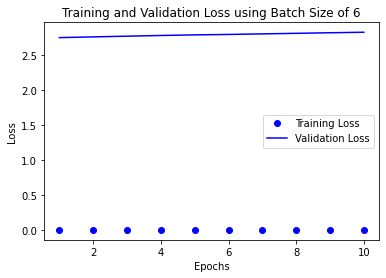

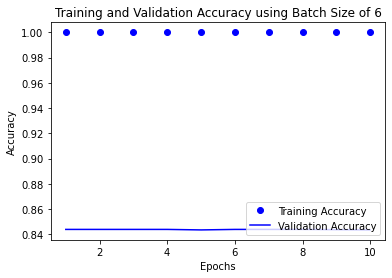

In [44]:
batch_grid_vals = [2,4,6]
for num_batch in batch_grid_vals:
  print(f"Training with a batch size of {num_batch}")
  history = model_bilstm.fit(train_ds, validation_data=val_ds, epochs=10, batch_size=num_batch)
  loss, accuracy = model_bilstm.evaluate(test_ds)

  print(f"On the test data using a batch size of {num_batch} produces a loss of {loss}")
  print(f"On the test data using a batch size of {num_batch} produces a accuracy of {accuracy}")

  history_dict = history.history
  acc = history_dict['accuracy']
  val_acc = history_dict['val_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(acc) + 1)

  # "bo" is for "blue dot"
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training Loss')
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title(f'Training and Validation Loss using Batch Size of {num_batch}')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  plt.plot(epochs, acc, 'bo', label='Training Accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
  plt.title(f'Training and Validation Accuracy using Batch Size of {num_batch}')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.show()

# Alternative Model 6 Transformer Model 20 Epochs
Source: https://keras.io/examples/nlp/text_classification_with_transformer/

In [206]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [207]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [208]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=vocab_size)
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")
x_train = keras.utils.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.utils.pad_sequences(x_val, maxlen=maxlen)

25000 Training sequences
25000 Validation sequences


In [209]:
x_train

array([[   5,   25,  100, ...,   19,  178,   32],
       [   0,    0,    0, ...,   16,  145,   95],
       [   0,    0,    0, ...,    7,  129,  113],
       ...,
       [   0,    0,    0, ...,    4, 3586,    2],
       [   0,    0,    0, ...,   12,    9,   23],
       [   0,    0,    0, ...,  204,  131,    9]], dtype=int32)

In [210]:
y_train

array([1, 0, 0, ..., 0, 1, 0])

In [211]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [212]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    x_train, y_train, batch_size=32, epochs=20, validation_data=(x_val, y_val)
)

Epoch 1/20
782/782 [==============================] - 65s 81ms/step - loss: 0.3904 - accuracy: 0.8098 - val_loss: 0.3525 - val_accuracy: 0.8458
Epoch 2/20
782/782 [==============================] - 63s 81ms/step - loss: 0.2048 - accuracy: 0.9209 - val_loss: 0.3091 - val_accuracy: 0.8742
Epoch 3/20
782/782 [==============================] - 63s 81ms/step - loss: 0.1375 - accuracy: 0.9502 - val_loss: 0.3906 - val_accuracy: 0.8643
Epoch 4/20
782/782 [==============================] - 63s 81ms/step - loss: 0.0902 - accuracy: 0.9679 - val_loss: 0.4837 - val_accuracy: 0.8541
Epoch 5/20
782/782 [==============================] - 63s 80ms/step - loss: 0.0595 - accuracy: 0.9802 - val_loss: 0.4873 - val_accuracy: 0.8514
Epoch 6/20
782/782 [==============================] - 63s 81ms/step - loss: 0.0405 - accuracy: 0.9869 - val_loss: 0.7386 - val_accuracy: 0.8419
Epoch 7/20
782/782 [==============================] - 63s 80ms/step - loss: 0.0355 - accuracy: 0.9894 - val_loss: 0.7731 - val_accuracy:

# Alternative Model 7 - Same as Alternative Model 6 except that the sequence length (maxlen) was increased to 650 

In [213]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 650  # increased to 650 previously, Only consider the first 200 words of each movie review
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=vocab_size)
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")
x_train = keras.utils.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.utils.pad_sequences(x_val, maxlen=maxlen)

25000 Training sequences
25000 Validation sequences


In [214]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model_t2 = keras.Model(inputs=inputs, outputs=outputs)

In [215]:
model_t2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model_t2.fit(
    x_train, y_train, batch_size=32, epochs=20, validation_data=(x_val, y_val)
)

Epoch 1/20
782/782 [==============================] - 697s 890ms/step - loss: 0.4390 - accuracy: 0.7642 - val_loss: 0.2840 - val_accuracy: 0.8812
Epoch 2/20
782/782 [==============================] - 688s 880ms/step - loss: 0.2025 - accuracy: 0.9237 - val_loss: 0.2706 - val_accuracy: 0.8882
Epoch 3/20
782/782 [==============================] - 688s 880ms/step - loss: 0.1287 - accuracy: 0.9568 - val_loss: 0.3363 - val_accuracy: 0.8764
Epoch 4/20
782/782 [==============================] - 688s 880ms/step - loss: 0.0799 - accuracy: 0.9740 - val_loss: 0.4985 - val_accuracy: 0.8596
Epoch 5/20
782/782 [==============================] - 688s 881ms/step - loss: 0.0567 - accuracy: 0.9826 - val_loss: 0.4935 - val_accuracy: 0.8597
Epoch 6/20
782/782 [==============================] - 688s 880ms/step - loss: 0.0378 - accuracy: 0.9885 - val_loss: 0.6231 - val_accuracy: 0.8545
Epoch 7/20
782/782 [==============================] - 689s 881ms/step - loss: 0.0260 - accuracy: 0.9919 - val_loss: 0.7661 -

# Alternative Model 8 - Similar to alternative model 7 except that batch size was decreased to 16 previously 32

In [216]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 650  # increased to 650 previously, Only consider the first 200 words of each movie review
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=vocab_size)
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")
x_train = keras.utils.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.utils.pad_sequences(x_val, maxlen=maxlen)

25000 Training sequences
25000 Validation sequences


In [217]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model_t2 = keras.Model(inputs=inputs, outputs=outputs)

In [218]:
model_t2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model_t2.fit(
    x_train, y_train, batch_size=16, epochs=20, validation_data=(x_val, y_val)
)

Epoch 1/20
1563/1563 [==============================] - 705s 450ms/step - loss: 0.3873 - accuracy: 0.8040 - val_loss: 0.2788 - val_accuracy: 0.8891
Epoch 2/20
1563/1563 [==============================] - 705s 451ms/step - loss: 0.1911 - accuracy: 0.9282 - val_loss: 0.3343 - val_accuracy: 0.8684
Epoch 3/20
1563/1563 [==============================] - 703s 450ms/step - loss: 0.1220 - accuracy: 0.9584 - val_loss: 0.3561 - val_accuracy: 0.8694
Epoch 4/20
1563/1563 [==============================] - 703s 450ms/step - loss: 0.0734 - accuracy: 0.9764 - val_loss: 0.5340 - val_accuracy: 0.8579
Epoch 5/20
1563/1563 [==============================] - 705s 451ms/step - loss: 0.0511 - accuracy: 0.9831 - val_loss: 0.6371 - val_accuracy: 0.8583
Epoch 6/20
1563/1563 [==============================] - 704s 450ms/step - loss: 0.0337 - accuracy: 0.9888 - val_loss: 0.8225 - val_accuracy: 0.8512
Epoch 7/20
1563/1563 [==============================] - 704s 450ms/step - loss: 0.0236 - accuracy: 0.9919 - val_

KeyboardInterrupt: 

# Summary

The first alternative model I tried was identical to the original model except that I increased the sequence length to 650 previously 250. The value 650 was utilized since its a number that is close to the mode text length in the training and testing data. The results of this model were very similar to the original model with only a very slight improvement in val_binary_accuracy (increased to 0.8808 previously 0.879). The second alternative model I tried was identical to the original model except that I increased sequence length to 650 previously 250 (same as first alternative model), decreased max_features to 5,000 previously 10,000, and increased epochs to 20 previously 10. The results of this model showed a slight improvement relative to the original model specifically the loss and validation loss both decreased a bit and the binary_accuracy and val_binary_accuracy (became 0.8842 previously 0.8790) both increased a bit. However, the amount in improvement was very small. The third alternative model was identical to the second alternative model except that the embedding dimensions was increased to 50 previously 16. This change was done to see if a larger embedding dimension value helped capture more details of the relationship between the words in the text. The values at epoch 20 of loss, binary_accuracy, val_loss, and val_binary_accuracy were very similar to the second alternative model. The early epochs in alternative model three had metrics that were quite a bit different from the second alternative model however, by epoch 20 they became similar.  Since changing these various parameters of the original model did not influence the metrics by much, I then decided to try a different model. For the alternative model four I used a bidirectional LSTM model. For the alternative model four I used a sequence length of 650 instead of 250 as the original model used, and kept the max features at 10,000 and epochs at 10 as it was in the original model.  The time to train each epoch increased drastically, previously it took a few seconds, but with this model it took over 800ms for each epoch. Surprisingly, this model had all the metrics except training loss perform much worse than the original model. For the alternative model five I continued to use a bidirectional LSTM model, but instead did a grid search by trying out different batch size values  including 2, 4, 6, 8, 16, 32, 64, skipped/paused training of batch size 128 and 256 since the results of the prior batch sizes were similar (best batch size was 16 with a val_accuracy of 0.8574 at epoch 10). However, all the alternative model five tried had very large values for validation loss. The alternative model five did not perform better than the original model. Next I tried a transformer model for alternative model 6. I trained the model for 20 epochs, used 200 for the sequence length, and 32 for the batch size.  The loss and accuracy on the training data improved, however the validation loss did not improve it instead increased drastically in comparison to our original model. The validation accuracy for this transformer model was slightly lower than the validation binary accuracy in the original model. The metrics for this model showed that the model was overfitting to the training data. Afterwards, for my alternative model 7, I tried an identical model to alternative model 6 except that I increased the sequence length to 650 previously 200. The validation accuracy values were similar to the original model, not much improvement. The first and second epoch of this model had slightly higher values for the val_accuracy, but as the epochs progressed the validation loss increased by a lot, while the metrics for the training data showed overfitting.  Lastly, I tried alternative model 8, which was similar to alternative model 7 except that I decreased the batch size to 16. I initally set it to run through 20 epochs as well, however after seeing the first 7 epochs having similar results, I stopped the trainnig early. None of the models I tried listed above improved the validation accuracy significantly. Future research, other models I would be interested in trying would be BERT and adding in some regularization techniques to see if it helps with the overfitting issue. 